In [ ]:
#import waymo open dataset
#train using mlp
#use cnn
#use different optimizer, "adam", "sgd"
#for analysis give us rmse and plot it using matplotlib

In [ ]:
import pandas as pd
import cmath
import math
import numpy as np
import glob
from os import path
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold

In [ ]:
# load the dataset from the Google Drive location
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
num_of_sensors = 24

def prepare_data_conv2d(df):
  X = []
  for c_arr in df['sensor']:
    # use real, imag  and angle values as features
    X.append([i.real for i in c_arr] + [i.imag for i in c_arr] + [np.angle(i) for i in c_arr])
  X = np.asarray(X).astype('float32')

  # 3 channels : real part, imag part and angle values
  num_of_samples = X.shape[0]
  X = X.reshape(num_of_samples, num_of_sensors, num_of_sensors)
  print("X.shape:", X.shape)

  # Two targets: tgtAz and tgtEl
  Y_az = df['tgtAz']
  Y_az = np.asarray(Y_az).astype('float32')

  Y_el = df['tgtEl']
  Y_el = np.asarray(Y_el).astype('float32')

  Y = np.stack((Y_az, Y_el), axis=1)
  print(Y.shape)

  return X,Y

In [ ]:
!ls /content/drive/MyDrive/RTD_ML_DATASETS/'data in pickle format'/data_all_281221.pkl

'/content/drive/MyDrive/RTD_ML_DATASETS/data in pickle format/data_all_281221.pkl'


In [ ]:
#dataset path
path_data_all = '/content/drive/MyDrive/RTD_ML_DATASETS/data in pickle format/data_all_281221.pkl'
data_all = pd.read_pickle(path_data_all)

In [ ]:
data_all.head()

,sensor,tgtAz,tgtEl,tgtAmpAbs,tgtAmpReal,tgtAmpImag,snr
0,"[(0.43328781612678996+0.974769581274364j), (0....",-20.459838,-1.234783,1,0.676347,-0.736583,05dB
1,"[(0.159028314259432+0.689512404819059j), (0.97...",-28.701215,-4.061009,1,-0.994969,-0.100179,05dB
2,"[(-1.05467342650783+0.300623242518138j), (-0.9...",-38.895201,0.549737,1,-0.973491,-0.228727,05dB
3,"[(0.41228084507665397+0.146073278265548j), (1....",8.194873,1.923607,1,0.331567,-0.943432,05dB
4,"[(1.5585688445022698+0.23542451522124105j), (-...",6.027422,0.802594,1,-0.999427,0.033836,05dB


In [ ]:
#print the number of samples for each SNR level
df = data_all
for snr in df.snr.unique():
  _df = df.loc[df.snr == snr]
  print(snr, '=', len(_df.index))

05dB = 30000
00dB = 35000
20dB = 25000
10dB = 25000
nonoise = 49998
minus5dB = 5000
minus10dB = 5000
minus15dB = 5000


In [ ]:
df = data_all

db_list  = ['nonoise'] #use only data with no noise
#db_list  = ['nonoise', '20dB', '10dB'] #put the list of data types you want to use

df_train = []
df_test = []
for snr in db_list:
  _df = df.loc[df.snr == snr].sample(25000, random_state=33)
  train, test = train_test_split(_df, test_size=0.2, random_state=33)
  df_train.append(train)
  df_test.append(test)

df_train = pd.concat(df_train)
df_test = pd.concat(df_test)
print("train and test data are ready")

train and test data are ready


In [ ]:
# train_data = df_train
# train_data['label'] = train_data['label'].astype(str)
# Y = train_data[['label']]

# skf = KFold(n_splits = 5, random_state = 7, shuffle = True) 

# fold = 1
# for train_index, val_index in skf.split(np.zeros(len(train_data)), Y):
  
#   training_data = train_data.iloc[train_index]
#   validation_data = train_data.iloc[val_index]

In [ ]:
X_train, y_train = prepare_data_conv2d(df_train)
X_test, y_test = prepare_data_conv2d(df_test)

X.shape: (20000, 24, 24)
(20000, 2)
X.shape: (5000, 24, 24)
(5000, 2)


In [ ]:
import os
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense


from keras.metrics import RootMeanSquaredError
from sklearn.model_selection import cross_val_score

In [ ]:
# save the model with the lowest val_loss
checkpoint_path = "expCNN01/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 #save_weights_only=True,
                                                 save_best_only = True,
                                                 monitor='val_loss',
                                                 verbose=1)

In [ ]:
inp_size = num_of_sensors
kernel_size = 3
tf.keras.backend.clear_session()

# A baseline CNN model
def baseline_model():
  model = Sequential()
  model.add(Conv2D(filters=64, kernel_size=kernel_size, activation='relu', input_shape=(24, 24, 1)))
  model.add(Conv2D(filters=64, kernel_size=kernel_size, activation='relu'))

  # model.add(MaxPooling2D(pool_size=2)) #note that not using MaxPooling increased the accuracy
  
  model.add(Flatten())
  model.add(Dense(256, activation='relu'))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(2, activation='relu'))
  model.compile(
    optimizer='adam',
    loss='mse',
    metrics=[RootMeanSquaredError()])
  return model

In [ ]:
model = baseline_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 22, 22, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 20, 20, 64)        36928     
                                                                 
 flatten (Flatten)           (None, 25600)             0         
                                                                 
 dense (Dense)               (None, 256)               6553856   
                                                                 
 dense_1 (Dense)             (None, 64)                16448     
                                                                 
 dense_2 (Dense)             (None, 2)                 130       
                                                                 
Total params: 6,608,002
Trainable params: 6,608,002
Non-

In [ ]:
history = model.fit(X_train, 
          y_train,
          epochs=10, #try it with at least 100 epochs
          batch_size=32,
          validation_split=0.2,
          callbacks=[cp_callback])

Epoch 1/10
500/500 [==============================] - ETA: 0s - loss: 268.5086 - root_mean_squared_error: 16.3862
Epoch 1: val_loss improved from inf to 272.86923, saving model to expCNN01/cp.ckpt
INFO:tensorflow:Assets written to: expCNN01/cp.ckpt/assets
500/500 [==============================] - 98s 195ms/step - loss: 268.5086 - root_mean_squared_error: 16.3862 - val_loss: 272.8692 - val_root_mean_squared_error: 16.5188
Epoch 2/10
500/500 [==============================] - ETA: 0s - loss: 268.5069 - root_mean_squared_error: 16.3862
Epoch 2: val_loss did not improve from 272.86923
500/500 [==============================] - 52s 105ms/step - loss: 268.5069 - root_mean_squared_error: 16.3862 - val_loss: 272.8692 - val_root_mean_squared_error: 16.5188
Epoch 3/10
500/500 [==============================] - ETA: 0s - loss: 268.5068 - root_mean_squared_error: 16.3862
Epoch 3: val_loss did not improve from 272.86923
500/500 [==============================] - 52s 104ms/step - loss: 268.5068 - r

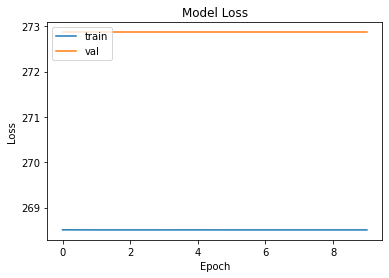

In [ ]:
#how was the training, any overfits?
# plot train loss and validation loss for each epoch

from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

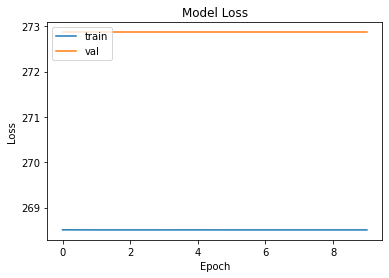

In [ ]:
#how was the training, any overfits?
# plot train loss and validation loss for each epoch

from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
def get_result(model, X_test, y_test):

  test_loss = model.evaluate(X_test, y_test)

  preds = model.predict(X_test)
  np.sum(abs(np.subtract(preds, y_test)))

  _error_azimuth = abs(np.subtract(preds[:,0], y_test[:,0]))

  _error_elevation = abs(np.subtract(preds[:,1], y_test[:,1]))

  _error_ang = np.sqrt(_error_azimuth**2+_error_elevation**2)

  # some statistics of the errors
  _error_df = pd.DataFrame({'_error_azimuth': _error_azimuth, '_error_elevation': _error_elevation,
                            '_error_ang': _error_ang})

  print(_error_df.describe().apply(lambda s: s.apply('{0:.3f}'.format)))
